In [1]:
import math
import bisect
from collections import defaultdict
import copy
from enum import Enum
import random
import numpy as np
import pandas
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import scipy.stats
from matplotlib import colormaps
import cmasher as cmr

In [2]:
class InfectionStatus(Enum):
    """The various possible states of a persons infection with the disease.
    """
    SUSCEPTIBLE = 0
    INFECTED = 1
    RECOVERED = 2

In [3]:
def sample_discrete(p):
    cumulative_distribution = np.cumsum(p)
    return bisect.bisect(cumulative_distribution, np.random.random() * cumulative_distribution[-1])

In [4]:
class PersonCollection:
    """A collection of persons.

    It supports adding people, removing people, and randomly sampling people
    faster than just a list, by simultaneously saving the index of each
    person in a dictionary.

    See https://stackoverflow.com/questions/15993447/python-data-structure-for-efficient-add-remove-and-random-choice  # noqa
    for discussion.
    """
    def __init__(self):
        """Initialize an empty collection.
        """
        self.persons = []
        self.persons_map = dict()

    def add_person(self, person):
        """Add a person to this collection.

        Parameters
        ----------
        person : simsurveillance.Person
            Person to be added
        """
        if person not in self.persons_map:
            self.persons.append(person)
            self.persons_map[person] = len(self.persons) - 1

    def remove_person(self, person):
        """Remove a person from this collection.

        Parameters
        ----------
        person : simsurveillance.Person
            Person to be removed
        """
        map_location = self.persons_map.pop(person)
        last_person = self.persons.pop()

        # If the person requested to be removed happened to be the last, no
        # further action is necessay. Otherwise, now slot in the last person
        # wherever the person was removed.
        if map_location == len(self.persons):
            return
        self.persons[map_location] = last_person
        self.persons_map[last_person] = map_location

    def random_people(self, num):
        """Select people, at random, without replacement from the collection.

        Parameters
        ----------
        num : int
            Number to randomly sample

        Returns
        -------
        list
            List of people who happened to be chosen
        """
        return random.sample(self.persons, num)

    def shuffle(self):
        """Randomize the order of persons in this collection.
        """
        new_persons = []
        new_persons_map = dict()

        random.shuffle(self.persons)
        for person in self.persons:
            new_persons.append(person)
            new_persons_map[person] = len(new_persons) - 1

        self.persons = new_persons
        self.persons_map = new_persons_map

    def __iter__(self):
        return iter(self.persons)

    def __len__(self):
        return len(self.persons)

    def __contains__(self, person):
        return person in self.persons_map

    def __getitem__(self, i):
        return self.persons[i]

In [166]:
class Agent:

    def __init__(self, model):
        self.infection_status = InfectionStatus.SUSCEPTIBLE
        self.model = model
        self.next_status_update = None

        self.number_of_times_infected = 0
        self.last_time_infected = -1

        self.generation_intervals = []
        self.profile = []

        for t in range(500):
            self.profile.append(self.model.generation_interval_distribution.pdf(t))

    def update_status(self, t):
        # Update myself
        old_status = self.infection_status
        next_status = InfectionStatus((old_status.value + 1) % len(InfectionStatus))
        self.infection_status = next_status

        # Update model
        self.model.persons[old_status].remove_person(self)
        self.model.persons[next_status].add_person(self)

        # Get next change
        if next_status == InfectionStatus.INFECTED:
            # delay = sample_discrete(self.model.f_infectious)
            # delay = 16
            delay = 10
            self.next_status_update = t + delay
            self.model.transitions[self.next_status_update].append(self)

            self.model.new_infectees[t].append(self)
            self.number_of_times_infected += 1
            self.last_time_infected = t

        elif next_status == InfectionStatus.RECOVERED:
            delay = sample_discrete(self.model.f_recovered)
            self.next_status_update = t + delay
            self.model.transitions[self.next_status_update].append(self)

        elif next_status == InfectionStatus.SUSCEPTIBLE:
            self.next_status_update = None

In [167]:
class ModelStep:
    """One step in an agent based model.

    Attributes
    ----------
    model : simsurveillance.AgentModel
        Model to which this step is attached.
    """
    def __init__(self, model):
        self.model = model

    def __call__(self, time):
        """Run this step at the indicated time point.

        Parameters
        ----------
        time : int
            Time step
        """
        raise NotImplementedError
    

class InfectionProgressionStep(ModelStep):
    """Transition persons from I to R, or from R to S.
    """

    def __call__(self, time):
        for person in copy.copy(self.model.transitions[time]):
            self.model.transitions[time].remove(person)
            person.update_status(time)


class TransmissionStep(ModelStep):
    """Infects persons from S to I, based on transmission from other
    infectious.
    """
    def __init__(self, model):
        super().__init__(model)
        self.num_infected = 0

    def _transmission_rate(self, num_susceptible, infector, time):

        # r = self.model.transmission_rate(time) * num_susceptible / self.model.N
        # return r
        
        R = infector.profile[time - infector.last_time_infected] * self.model.transmission_rate(time) * num_susceptible / self.model.N
        return R

    def _compute_number_to_infect(self, rate):
        return np.random.poisson(rate)

    def __call__(self, time):
        infected_this_time_step = self.model.persons[InfectionStatus.INFECTED]
        num_susceptible_this_time_step = \
            len(self.model.persons[InfectionStatus.SUSCEPTIBLE])

        self.num_infected = 0

        for infector in copy.copy(infected_this_time_step.persons):
            rate_to_infect = \
                self._transmission_rate(num_susceptible_this_time_step, infector, time)
            
            if rate_to_infect <= 0:
                continue

            num_to_infect = self._compute_number_to_infect(rate_to_infect)

            if num_to_infect > num_susceptible_this_time_step:
                num_to_infect = num_susceptible_this_time_step

            persons_to_infect = \
                self.model.persons[InfectionStatus.SUSCEPTIBLE]\
                    .random_people(num_to_infect)
            
            for person in persons_to_infect:
                person.update_status(time)

                self.model.contact_tracings.append([id(infector), infector.last_time_infected, id(person), time])

            self.num_infected += num_to_infect
            num_susceptible_this_time_step -= num_to_infect

In [168]:
class Test:
    """Imperfect binary testing process

    Attributes
    ----------
    sensitivity : float
        Probability of testing positive, when applied to a truly positive
    specificity : float
        Probability of testing negative, when applied to a truly negative
    positive_statuses : list of simsurveillance.InfectionStatus
        Which states count as truly positive for this test.
    cost : float
        Positive number representing the surveillance effort of this test.
    """
    def __init__(self, sensitivity=1.0, specificity=1.0):
        self.sensitivity = sensitivity
        self.specificity = specificity

        self.positive_states = [InfectionStatus.INFECTED]

        self.cost = 1.0

    def __call__(self, person):
        """Obtain the test result of testing a person.

        Parameters
        ----------
        person : Person
            Person to be tested.
        time : int
            Time when this test is being conducted
        """
        if person.infection_status in self.positive_states:
            if random.random() < self.sensitivity:
                return True
            else:
                return False

        else:
            if random.random() < self.specificity:
                return False
            else:
                return True


class Observer:
    """Observation process of an epidemic.

    An observer is called at each simulation time step of the agent based
    model. It can extract exact information or simulate some testing process
    applied to a randomly or deterministically selected subset of the
    population.
    """

    def __init__(self, model):
        """
        Parameters
        ----------
        model : simsurveillance.AgentModel
            Agent based model
        """
        self.model = model

    def __call__(self, time):
        raise NotImplementedError
    

class ReportedCases(Observer):

    def __init__(self, model, test):
         super().__init__(model)
         self.test = test

         self.times = []
         self.cases = []
    
    def __call__(self, time):
        cases_t = 0
        for person in self.model.new_infectees[time]:
            if random.random() < self.model.case_ascertainment(time):
                result = self.test(person)
                if result:
                    cases_t += 1

        self.times.append(time)
        self.cases.append(cases_t)


class Survey(Observer):

    def __init__(self, model, test, start_dates, sample_size, duration):
        super().__init__(model)

        self.test = test
        self.start_dates = start_dates
        self.sample_size = sample_size
        self.duration = duration
        self.end_dates = np.asarray(self.start_dates) + duration

        self.times = []
        self.num_tested = []
        self.num_positive = []

    def __call__(self, time):
        if time in self.start_dates:

            to_be_tested = self.model.all_persons.random_people(self.sample_size)

            num_positive = 0
            for p in to_be_tested:
                result = self.test(p)
                if result:
                    num_positive += 1

            self.times.append(time)
            self.num_tested.append(self.sample_size)
            self.num_positive.append(num_positive)

In [ ]:
class Model:

    def __init__(self, N, num_init_infected):

        f_mean = 8
        f_var = 10
        
        f_mean = 4
        f_var = 2

        theta = f_var / f_mean
        k = f_mean / theta
        self.generation_interval_distribution = scipy.stats.gamma(k, scale=theta)

        self.N = N
        self.transitions = defaultdict(list)
        self.new_infectees = defaultdict(list)

        self.persons = {status: PersonCollection() for status in InfectionStatus}
        self.all_persons = PersonCollection()

        self.f_infectious = [0, 0, 0.1, 0.5, 0.4]
        self.f_recovered = [0] * 25 + [1]
        
        # Initialize all agents as susceptible
        for _ in range(N):
            a = Agent(self)
            self.persons[InfectionStatus.SUSCEPTIBLE].add_person(a)
            self.all_persons.add_person(a)

        # Set initial infected agents
        to_infect = self.persons[InfectionStatus.SUSCEPTIBLE].random_people(num_init_infected)
        for a in to_infect:
            a.update_status(0)

        self.transmission_rate = lambda x: 1.0
        self.case_ascertainment = lambda x: 1.0

        self.transmission_step = TransmissionStep(self)
        self.infection_progression_step = InfectionProgressionStep(self)

        self.contact_tracings = []

    def output_contact_tracings(self):
        return pandas.DataFrame(self.contact_tracings, columns=['infector_id', 'date_infector_infected', 'infectee_id', 'date_infectee_infected'])

    def add_observers(self, observers):
        self.observers = observers

    def simulate(self, T):
        output = defaultdict(list)

        for t in range(1, T+1):

            output['time'].append(t)
            for status in InfectionStatus:
                output[status].append(len(self.persons[status]))
            output['transmissions'].append(
                self.transmission_step.num_infected)

            # Simulation steps --------------------------
            self.transmission_step(t)
            self.infection_progression_step(t)
            # -------------------------------------------

            # Observation steps --------------------------
            for observer in self.observers:
                observer(t)
            # -------------------------------------------

        return pandas.DataFrame(output)

In [ ]:
parameters = [
    [0.35, 1000, 3, 10],
]

all_data = []
ki = 1

for params in parameters:
    
    def transmission_rate(t):
        change_point = 1000
        if t < change_point:
            return 3.0
        elif change_point <=  t < 2 * change_point:
            return 2.0 - 0.0075 * (t - change_point)
        else:
            return 2.0 - 0.0075 * change_point
 
    f_mean = 1000
    f_var = 100 ** 2
    theta = f_var / f_mean
    k = f_mean / theta
    f_dist = scipy.stats.gamma(k, scale=theta)
    f_recovered = f_dist.pdf(np.arange(2000))

    f_mean = params[1]
    f_var = params[2] ** 2
    theta = f_var / f_mean
    k = f_mean / theta
    f_dist = scipy.stats.gamma(k, scale=theta)
    f_infectious = f_dist.pdf(np.arange(40))

    ########
    samples = 1
    R = 2
    gi = []

    for _ in range(samples):

        days = sample_discrete(f_infectious)

        for i in range(days + 1):
            if i > 0:
                num_to_infect = scipy.stats.poisson(R).rvs()
                gi += [i] * num_to_infect

    intrinsic_mean = np.mean(gi)
    intrinsic_std = np.std(gi)
    #######

    m = Model(100000, params[3])
    m.transmission_rate = transmission_rate

    m.f_infectious = f_infectious
    m.f_recovered = f_recovered

    m.add_observers([])

    df_output = m.simulate(100)

    df = m.output_contact_tracings()
    df['difference'] = df['date_infectee_infected'] - df['date_infector_infected']

    ts = []
    means = []
    data = []
    ns = []
    for t in sorted(list(set(df['date_infector_infected']))):
        ts.append(t)
        means.append(np.mean(df[df['date_infector_infected'] == t]['difference']))
        data.append(df[df['date_infector_infected'] == t]['difference'].to_numpy())
        ns.append(len(df[df['date_infector_infected'] == t]['difference']))

    all_data.append([params[0], f_infectious, df, df_output, ts, means, data, ns, params[3], params[1], params[2], intrinsic_mean])

    df.to_csv('data/epidemic_{}__({}_{}_{}_{}).csv'.format(ki, *params))
    ki += 1

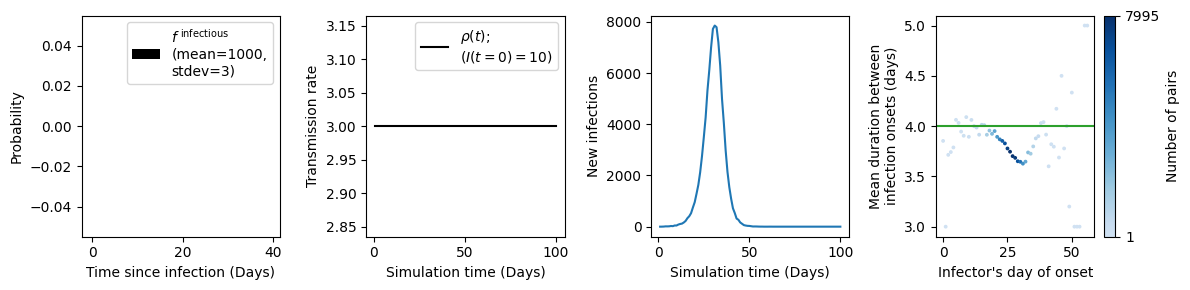

In [172]:
cmap = cmr.get_sub_cmap('Blues', 0.2, 1)

fig = plt.figure(figsize=(12, 3))

n_rows = len(all_data)

ax1 = None
ax2 = None
ax3 = None
ax4 = None

for nr, row in enumerate(all_data):

    transmission_rate_param, f_infectious, df, df_output, ts, means, data, ns, N, mean, std, gi_mean = row

    # def transmission_rate(t):
    #     return transmission_rate_param

    ax1 = fig.add_subplot(n_rows, 4, 4 * nr + 1, sharey=ax1)
    ax1.bar(np.arange(len(f_infectious)), f_infectious, label=r'$f^\text{ infectious}$' + '\n(mean={},\nstdev={})'.format(mean, std), color='k')

    ax1.legend()
    ax1.set_xlabel('Time since infection (Days)')
    ax1.set_ylabel('Probability')

    ax2 = fig.add_subplot(n_rows, 4, 4 * nr + 2, sharey=ax2)
    tis = df_output['time']
    ax2.plot(tis, [transmission_rate(t) for t in tis], label=r'$\rho(t);$' + '\n' + r'($I(t=0)={}$)'.format(N), color='k')

    ax2.legend()
    ax2.set_xlabel('Simulation time (Days)')
    ax2.set_ylabel('Transmission rate')

    ax3 = fig.add_subplot(n_rows, 4, 4 * nr + 3, sharey=ax3)
    ax3.plot(df_output['time'], df_output['transmissions'], color='tab:blue')
    # ax3.plot(df_output['time'], df_output[InfectionStatus.SUSCEPTIBLE], color='tab:red')
    ax3.set_xlabel('Simulation time (Days)')
    ax3.set_ylabel('New infections')

    ax4 = fig.add_subplot(n_rows, 4, 4 * nr + 4, sharex=ax4)

    ax4.scatter(ts, means, c=[cmap(n/max(ns)) for n in ns], s=3)
    ax4.axhline(4, color="tab:green")
    bar = mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min(ns), vmax=max(ns), clip=True), cmap=cmap,)
    cax = fig.colorbar(bar, ax=ax4, orientation='vertical', label='Number of pairs')
    cax.set_ticks([min(ns), max(ns)])

    ax4.set_xlabel("Infector's day of onset")
    ax4.set_ylabel('Mean duration between\ninfection onsets (days)')

    # ax4.set_ylim(0, 6)

fig.set_tight_layout(True)
plt.savefig('Figure1.png')
plt.show()

In [17]:
def transmission_rate(t):
    return 0.4

f_mean = 8
f_dist = scipy.stats.expon(scale=f_mean)
f_infectious = f_dist.pdf(np.arange(25))

f_mean = 100
f_dist = scipy.stats.expon(scale=f_mean)
f_recovered = f_dist.pdf(np.arange(2000))

In [53]:
def transmission_rate(t):
    return 0.3

f_mean = 12
f_var = 4 ** 2
theta = f_var / f_mean
k = f_mean / theta
f_dist = scipy.stats.gamma(k, scale=theta)
f_infectious = f_dist.pdf(np.arange(50))

f_mean = 1000
f_var = 100 ** 2
theta = f_var / f_mean
k = f_mean / theta
f_dist = scipy.stats.gamma(k, scale=theta)
f_recovered = f_dist.pdf(np.arange(2000))


<BarContainer object of 50 artists>

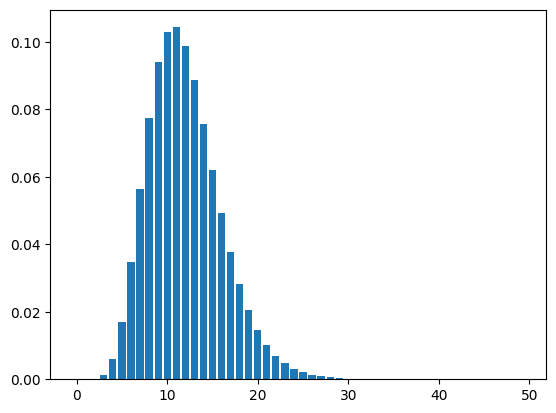

In [54]:
plt.bar(np.arange(len(f_infectious)), f_infectious)

In [ ]:
m = Model(100000, 5)
m.transmission_rate = transmission_rate

m.f_infectious = f_infectious
m.f_recovered = f_recovered

m.add_observers([])

df_output = m.simulate(100)

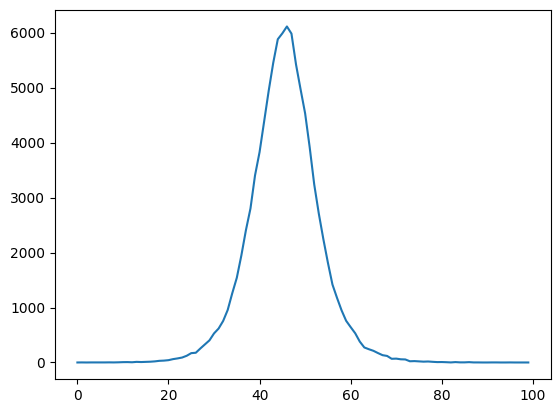

In [56]:
plt.plot(df_output['transmissions'])
plt.show()

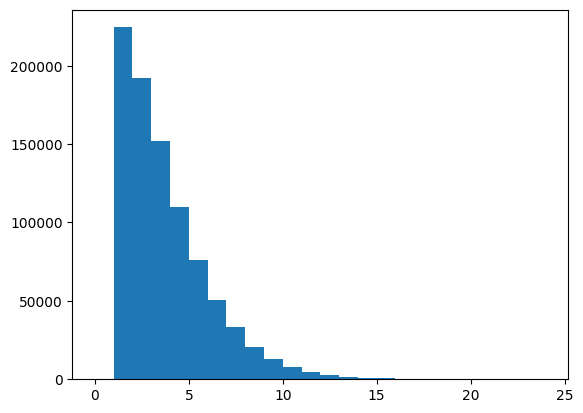

3.2891922845897996


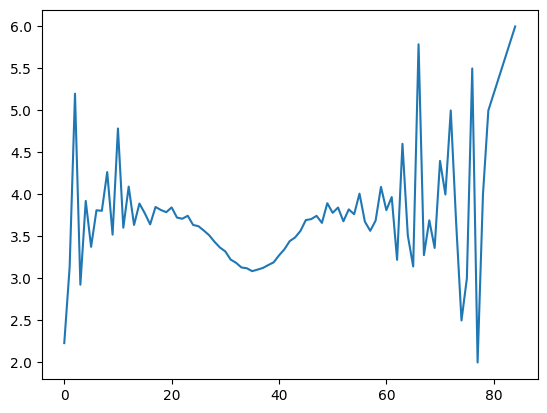

In [125]:
df = m.output_contact_tracings()
df['difference'] = df['date_infectee_infected'] - df['date_infector_infected']

df.to_csv('filename.csv')

plt.hist(df['difference'], bins=np.arange(0, 25))
plt.show()


print(np.mean(df['difference']))

ts = []
means = []
for t in sorted(list(set(df['date_infector_infected']))):
    ts.append(t)
    means.append(np.mean(df[df['date_infector_infected'] == t]['difference']))

plt.plot(ts, means)
plt.show()

In [69]:
df = m.output_contact_tracings()
df['difference'] = df['date_infectee_infected'] - df['date_infector_infected']

ts = []
means = []
data = []
ns = []
for t in sorted(list(set(df['date_infector_infected']))):
    ts.append(t)
    means.append(np.mean(df[df['date_infector_infected'] == t]['difference']))
    data.append(df[df['date_infector_infected'] == t]['difference'].to_numpy())
    ns.append(len(df[df['date_infector_infected'] == t]['difference']))



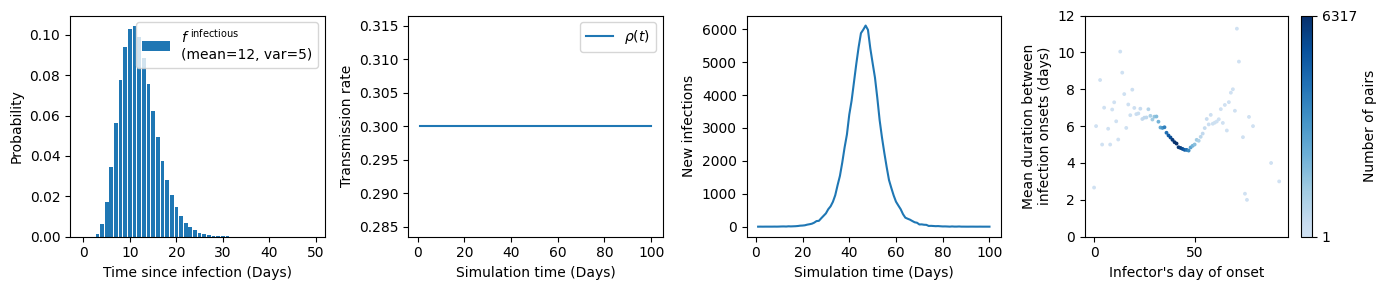

In [80]:
cmap = mpl.colormaps['Reds']
import cmasher as cmr
cmap = cmr.get_sub_cmap('Blues', 0.2, 1)

fig = plt.figure(figsize=(14, 3))

ax = fig.add_subplot(1, 4, 1)
ax.bar(np.arange(len(f_infectious)), f_infectious, label=r'$f^\text{ infectious}$' + '\n(mean=12, var=5)')

ax.legend()
ax.set_xlabel('Time since infection (Days)')
ax.set_ylabel('Probability')



ax = fig.add_subplot(1, 4, 2)
tis = df_output['time']
ax.plot(tis, [transmission_rate(t) for t in tis], label=r'$\rho(t)$')

ax.legend()
ax.set_xlabel('Simulation time (Days)')
ax.set_ylabel('Transmission rate')




ax = fig.add_subplot(1, 4, 3)

ax.plot(df_output['time'], df_output['transmissions'], color='tab:blue')

ax.set_xlabel('Simulation time (Days)')
ax.set_ylabel('New infections')


ax = fig.add_subplot(1, 4, 4)

ax.scatter(ts, means, c=[cmap(n/max(ns)) for n in ns], s=3)

bar = mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min(ns), vmax=max(ns), clip=True), cmap=cmap,)
cax = fig.colorbar(bar, ax=ax, orientation='vertical', label='Number of pairs')
cax.set_ticks([min(ns), max(ns)])

ax.set_xlabel("Infector's day of onset")
ax.set_ylabel('Mean duration between\ninfection onsets (days)')
ax.set_ylim(0, 12)


fig.set_tight_layout(True)
plt.show()